# Imports

In [1]:
# stdlib
import copy
import random
import itertools
import statistics
import multiprocessing

# data wrangling
import numpy as np
import pandas as pd
import statsmodels.api as sm

from scipy import stats
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# custom
from hotspot_classes import Hotspot
import hotspot_utils
import mlr_utils

n_processors = max([1,multiprocessing.cpu_count()-2])

with open('insults.txt', 'r') as f:
    insults = f.read().splitlines()

# Reading data - Works for single or double file layouts

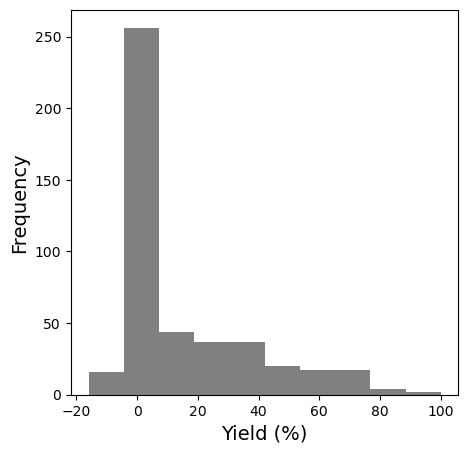

,Yield (%),x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x181,x182,x183,x184,x185,x186,x187,x188,x189,x190
R1_2,1.916534,-0.063670,1.784157,-0.206310,-0.023277,-0.114794,0.183033,0.036033,0.061658,-0.345264,...,6.572514,6.339063,7.850955,1.511892,6.407769,7.285463,6.908743,8.216943,1.308200,7.992698
R1_5,98.000000,-0.061351,1.816461,-0.218842,-0.030145,-0.124494,0.188697,0.041069,0.060353,-0.376125,...,6.497622,6.092458,7.055260,0.962802,6.376705,7.370445,7.021018,8.155038,1.134020,8.086289
R1_6,0.617317,-0.071244,1.780166,-0.209940,0.016420,-0.096760,0.226360,0.020681,0.083040,-0.388780,...,6.443564,6.443564,6.443564,0.000000,6.443564,6.952513,6.952513,6.952513,0.000000,6.952513
R1_8,0.851423,-0.067185,1.780165,-0.216880,0.036010,-0.090435,0.252890,0.016170,0.113990,-0.456130,...,4.894739,4.894739,4.894739,0.000000,4.894739,6.648917,6.648917,6.648917,0.000000,6.648917
R1_10,4.908090,-0.067275,1.781649,-0.217025,0.020780,-0.098122,0.237805,0.020244,0.090149,-0.396203,...,6.615313,6.374532,7.124679,0.750147,6.377288,7.056268,7.037797,7.146163,0.108366,7.099058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R5_796,-13.206800,-0.024164,1.903453,-0.257967,-0.078693,-0.168330,0.179275,0.079036,0.006817,-0.407675,...,6.954069,6.028940,7.391170,1.362230,6.086104,6.989464,6.925771,7.430007,0.504236,7.430007
R5_797,-12.784600,-0.024191,1.900147,-0.256970,-0.079570,-0.168270,0.177400,0.079805,0.011430,-0.415940,...,6.027940,6.027940,6.029321,0.001381,6.029321,6.909132,6.909131,6.918910,0.009778,6.918910
R5_798,-13.645200,-0.026401,1.900154,-0.254050,-0.079880,-0.166965,0.174170,0.080029,0.005780,-0.411720,...,6.034069,6.029424,6.034070,0.004646,6.034070,6.910345,6.910344,6.919218,0.008874,6.910344
R5_799,-10.548200,-0.041824,1.902125,-0.234732,-0.074462,-0.154597,0.160270,0.074580,0.027824,-0.397857,...,6.041513,6.039198,6.050017,0.010818,6.039198,6.954143,6.941776,6.999585,0.057808,6.941776


In [2]:
# This cell reads in parameters and response data from Excel files and combines them into a single dataframe
# It assumes a row of xID numbers, followed by a row of full parameter names
# Check cell outputs to make sure everything looks good

parameters_file = "Multi-Threshold Analysis Data" # Excel file to pull parameters from
parameters_sheet = "Suzuki Yields and Parameters" # Sheet in the Excel file to pull parameters from
parameters_start_col = 2   # 0-indexed column number where the parameters start
parameters_num_parameters = 190 # Number of parameters in the parameters file
parameters_num_responses = 450 # Number of samples/reactions in the parameters file
parameters_y_label_col = 0  # 0-indexed column number where the ligand labels are
parameters_header_rows = 0 # Number of rows to skip when reading the parameters

response_file = "Multi-Threshold Analysis Data" # Excel file to pull responses from
response_sheet = "Suzuki Yields and Parameters" # Sheet in the Excel file to pull responses from
response_num_samples = 450 # Number of samples/reactions in the response file
response_col = 1 # 0-indexed column number for the responses
response_y_label_col = 0  # 0-indexed column number where the ligand labels are
response_header_rows = 1 # Number of rows to skip when reading the responses

RESPONSE_LABEL = "Yield (%)" # How you want to refer to your response variable in the dataframe

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Actually start reading stuff into dataframes
parameters_df = pd.read_excel("./InputData/" + parameters_file + ".xlsx",
                              parameters_sheet,
                              header = parameters_header_rows,
                              index_col = parameters_y_label_col,
                              nrows = parameters_num_responses + 1,
                              usecols = list(range(0, (parameters_num_parameters + parameters_start_col)))
                              )
response_df = pd.read_excel("./InputData/" + response_file + ".xlsx",
                            response_sheet,
                            header = response_header_rows,
                            index_col = response_y_label_col,
                            nrows = response_num_samples,
                            usecols = list(range(0, response_col + 1))
                            )


# Drop any columns before parameters_start_col that are not the index column
parameters_columns_to_keep = [col for col in range(0, len(parameters_df.columns)) if col >= parameters_start_col-1]
parameters_df = parameters_df.iloc[:,parameters_columns_to_keep]

# Combine the two dataframes into the master dataframe
response_df.drop(response_df.columns[0:response_col-1], axis = 'columns', inplace = True)
data_df = response_df.merge(parameters_df, left_index = True, right_index = True)
data_df.columns.values[0] = RESPONSE_LABEL # Converts the output column name from whatever it is on the spreadsheet
data_df.dropna(inplace = True) # This covers the entire masking section and trims the dataframe down to only the rows relevant to this dataset

# This converts all the data to numeric values since it was reading them in as non-numeric objects for some reason
for column in data_df.columns:
    data_df[column] = pd.to_numeric(data_df[column], errors='coerce')

# Creates a dictionary to convert x# labels to full parameter names
parameter_names = list(parameters_df.iloc[0, :parameters_num_parameters])
parameter_x_labels = list(parameters_df.columns)[:parameters_num_parameters]
x_labelname_dict = dict(zip(parameter_x_labels, parameter_names))

# Print out the data distribution of the response variable
plt.figure(figsize=(5, 5))
plt.hist(data_df[RESPONSE_LABEL], color='grey')
plt.xlabel(RESPONSE_LABEL, fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.show()

# Display the dataframe
display(data_df)

# Basic visualization

## Histograms and univariate correlations

x1 - vmin_vmin_boltz


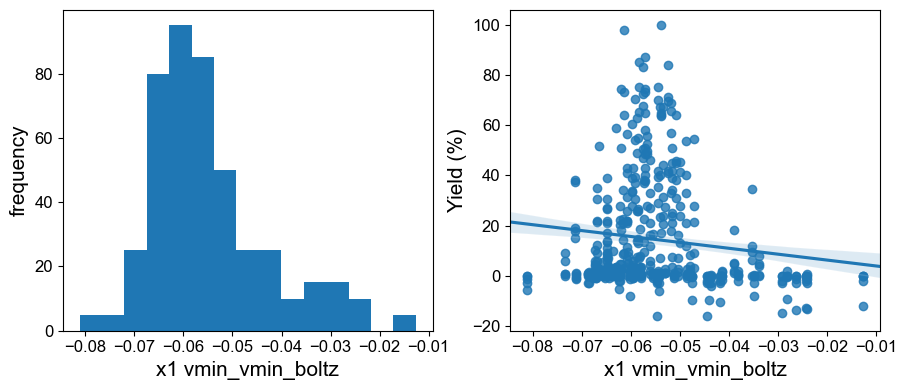

R^2 = 0.02; p-value = 6.95E-03

-------------------------------------------------------------------------------

x2 - vmin_r_boltz


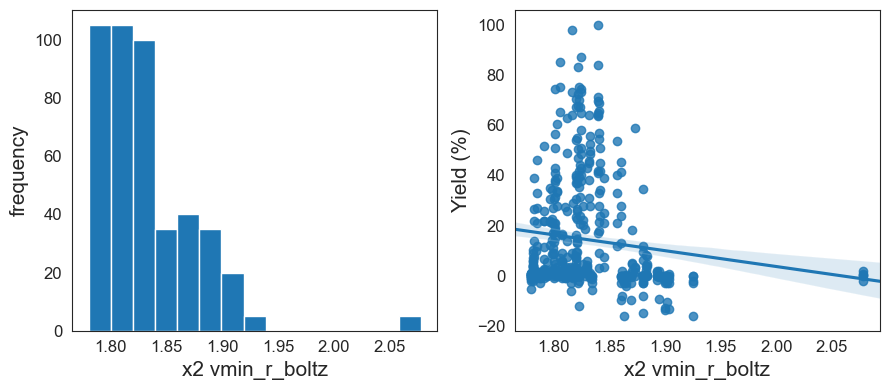

R^2 = 0.02; p-value = 8.31E-03

-------------------------------------------------------------------------------

x3 - fmo_e_homo_boltz


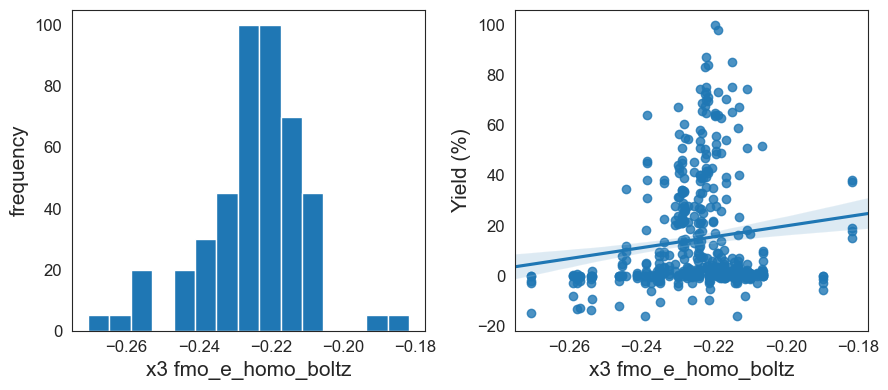

R^2 = 0.02; p-value = 4.26E-03

-------------------------------------------------------------------------------



In [3]:
# `features` should be a list of xID numbers you want to get the distribution and correlation for
# features = x_labels # Cycles through all features
features = ['x1','x2','x3'] # Gets the distribution and correlation for only the features listed

r2_cutoff = 0.0 # R^2 cutoff for correlation below which the feature will be skipped

# This feels like a relic of a bygone era, but here it is. 'matplotlib' refers to what was once the 'OG' cell.
visualization_type = 'seaborn' # 'matplotlib' or 'seaborn'

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

for feature in features:
    print(f'{feature} - {x_labelname_dict[feature]}')

    # If the feature has no variance it would break the math later on, so we skip it
    if data_df[feature].std() == 0:
        print("No variance in feature. Skipping.")
        continue

    # Get stats and line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df[feature], data_df[RESPONSE_LABEL])
    fit_line = intercept+slope*data_df[feature]

    # Skip the rest if R^2 is below the cutoff
    if r_value**2 < r2_cutoff:
        print("R^2 below cutoff. Skipping.")
        continue

    plt.figure(figsize=(9, 4))
    
    # Plot feature distribution
    plt.subplot(1,2,1)
    plt.hist(data_df[feature], bins=15)
    plt.ylabel("frequency",fontsize=15)
    plt.xlabel(f'{feature} {x_labelname_dict[feature]}',fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)

    # Plot univariate correlation
    plt.subplot(1,2,2)

    if visualization_type == 'matplotlib':
        plt.scatter(data_df[feature], data_df[RESPONSE_LABEL],color="black",marker="s",alpha=0.5)    
        plt.plot(data_df[feature],fit_line,color="black")
    elif visualization_type == 'seaborn':
        sns.set_style("white")
        sns.regplot(x=data_df[feature],y=data_df[RESPONSE_LABEL],ci=95,truncate=False)
        x_max=np.max(data_df[feature])
        x_min=np.min(data_df[feature])
        y_max=np.max(data_df[RESPONSE_LABEL])
        y_min=np.min(data_df[RESPONSE_LABEL])
        delta_x = 0.05 * (x_max-x_min)
        delta_y = 0.05 * (y_max-y_min)
        plt.xlim([x_min-delta_x,x_max+delta_x])
        plt.ylim([y_min-delta_y,y_max+delta_y])
    else:
        print(f'Invalid visualization type: {visualization_type}. Please fix and try again.')
        break

    plt.xlabel(f'{feature} {x_labelname_dict[feature]}',fontsize=15)
    plt.ylabel(RESPONSE_LABEL,fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12) 

    plt.tight_layout()
    plt.show()    

    if p_value > 0.01:
        print("R^2 = {:.2f}; p-value = {:.2f}".format(r_value**2,p_value))
    else:
        print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))
    print("\n-------------------------------------------------------------------------------\n")   

## Plot a feature vs. another feature

In [ ]:
# iIDs_1 and xIDs_2 should be lists of xID numbers you want to get the correlation for
# Set them to parameter_x_labels to get the correlation for all features, or specify a list of features to compare
xIDs_1 = parameter_x_labels
xIDs_2 = parameter_x_labels

# xIDs_1 = ['x1']
# xIDs_2 = ['x2']

r2_cutoff = 0.0 # R^2 cutoff for correlation below which the feature pair will be skipped

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

for feature_1,feature_2 in itertools.product(xIDs_1, xIDs_2):
    # No use wasting time comparing a feature to itself
    if feature_1 == feature_2:
        continue

    print(f'{feature_1} - {x_labelname_dict[feature_1]}')
    print(f'{feature_2} - {x_labelname_dict[feature_2]}')

    # If either feature has no variance it would break the math later on, so we skip it
    if data_df[feature_1].std() == 0 or data_df[feature_2].std() == 0:
        continue

    # Get stats and line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_df[feature_1], data_df[feature_2])
    fit_line = intercept+slope*data_df[feature_1]

    # Skip the rest if R^2 is below the cutoff
    if r_value**2 < r2_cutoff:
        print("R^2 below cutoff. Skipping.")
        print("\n-------------------------------------------------------------------------------\n")
        continue
    
    # Print p-values and R^2 values
    if p_value > 0.01:
        print("R^2 = {:.2f}; p-value = {:.2f}".format(r_value**2,p_value))
    else:
        print("R^2 = {:.2f}; p-value = {:.2E}".format(r_value**2,p_value))

    plt.figure(figsize=(16, 4))

    # Plot feature 1 distribution
    plt.subplot(1,3,1)
    plt.hist(data_df[feature_1], bins=15)
    plt.ylabel("frequency",fontsize=15)
    plt.xlabel(f'{feature} {x_labelname_dict[feature_1]}',fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)

    # Plot feature 2 distribution
    plt.subplot(1,3,2)
    plt.hist(data_df[feature_2], bins=15)
    plt.ylabel("frequency",fontsize=15)
    plt.xlabel(f'{feature} {x_labelname_dict[feature_2]}',fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)

    # Plot bivariate correlation
    plt.subplot(1,3,3)
    sns.set_style("white")
    sns.regplot(x=data_df[feature_1],y=data_df[feature_2],truncate=False)

    x_max=np.max(data_df[feature_1])
    x_min=np.min(data_df[feature_1])
    y_max=np.max(data_df[feature_2])
    y_min=np.min(data_df[feature_2])
    delta_x = 0.05 * (x_max-x_min)
    delta_y = 0.05 * (y_max-y_min)
    plt.xlim([x_min-delta_x,x_max+delta_x])
    plt.ylim([y_min-delta_y,y_max+delta_y])

    plt.xlabel(f'{feature_1} {x_labelname_dict[feature_1]}',fontsize=15)
    plt.ylabel(f'{feature_2} {x_labelname_dict[feature_2]}',fontsize=15)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12) 

    # Show the plots
    plt.tight_layout()
    plt.show()
    print("\n-------------------------------------------------------------------------------\n")
    

## Correlation Map

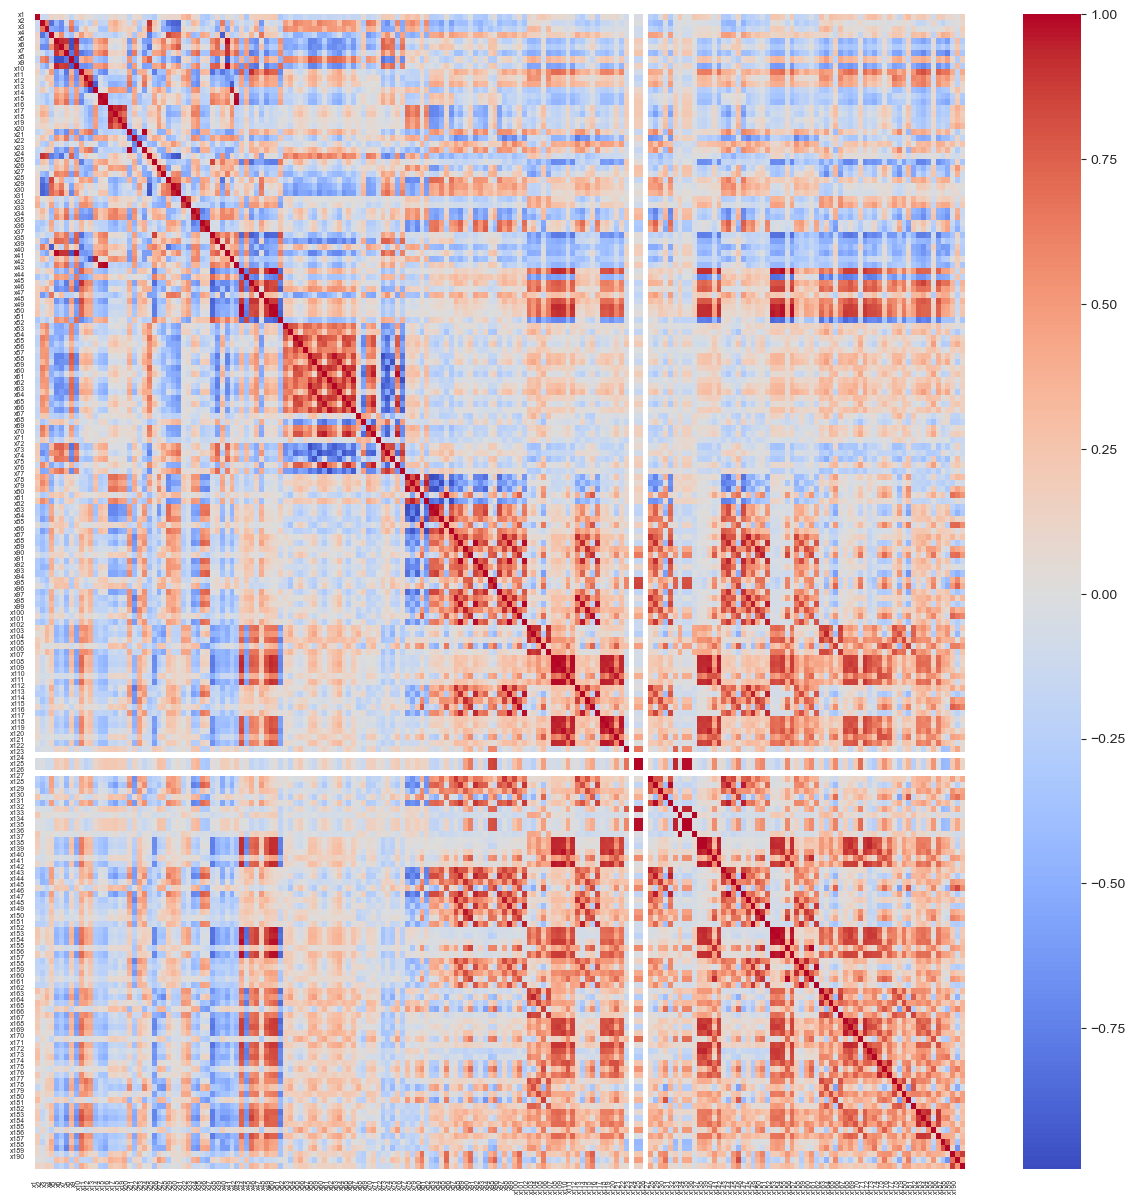

In [4]:
# Run to see how correlated the features are with each other

corrmap = data_df.corr()

plt.subplots(figsize=(15,15))
sns.heatmap(corrmap,center=0, annot=False, cmap="coolwarm", cbar=True) #linewidths=0.5
plt.xticks(range(len(parameter_x_labels)),parameter_x_labels, fontsize=5, rotation=90)
plt.yticks(range(len(parameter_x_labels)),parameter_x_labels, fontsize=5)
plt.show()

# Threshold Analysis

## Train / Test split

In [ ]:
# Split options are 'random', 'ks', 'y_equidistant', 'define', 'none'
split = "none"
test_ratio = 0.3 

# New train_test_splits set up returns the data_df index labels for the relevant points
training_set, test_set = hotspot_utils.train_test_splits(data_df, split, test_ratio, parameter_x_labels, RESPONSE_LABEL)

## Automatic Threshold Analysis

In [ ]:
# Cutoff in your output for what counts as an active ligand
y_cut = 10

# Set to True if you want points below the y-cut to be considered active
low_is_good = False

# How heavily to value active ligands (1) over inactive ligands (0)
class_weight = {1:10, 0:1} 

# How the prune_hotspots and find_best_hotspots evaluates which are the best
# Can be set to 'accuracy', 'weighted_accuracy', 'f1', and 'weighted_f1'
evaluation_method = 'weighted_accuracy'

# How many threshold dimensions do you want?
n_thresholds = 2

# What percentage of thresholds are analyzed in each subsequent step
percentage = 20

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Set up y_class, the binary list of which y values are above y_cut
hotspot_data_df = copy.deepcopy(data_df)
hotspot_data_df['y_class'] = 0

if(low_is_good):
    for i in hotspot_data_df.index:
        hotspot_data_df.loc[i, 'y_class'] = int(hotspot_data_df.loc[i, RESPONSE_LABEL] < y_cut)
else:
    for i in hotspot_data_df.index:
        hotspot_data_df.loc[i, 'y_class'] = int(hotspot_data_df.loc[i, RESPONSE_LABEL] > y_cut)

# Find the best thresholds within the full X and y space and make single threshold hotspot objects from them
all_thresholds = hotspot_utils.threshold_generation(hotspot_data_df, class_weight, evaluation_method, x_labelname_dict)
best_hotspots = []
for thresh in all_thresholds:
    temp_hs = Hotspot(hotspot_data_df, [thresh], y_cut, training_set, test_set, evaluation_method, class_weight)
    best_hotspots.append(temp_hs)

# Cut down to the best {percentage} hotspots
best_hotspots = hotspot_utils.prune_hotspots(best_hotspots, percentage, evaluation_method)

# Add more thresholds, pruning after each step for resource management
for i in range(n_thresholds - 1):
    with multiprocessing.Pool(processes=int(n_processors-2)) as p:
        new_hotspots = p.starmap(hotspot_utils.hs_next_thresholds_fast, zip(best_hotspots, itertools.repeat(all_thresholds)))
    new_hotspots = [item for sublist in new_hotspots for item in sublist] 
    
    best_hotspots = hotspot_utils.prune_hotspots(new_hotspots, percentage, evaluation_method)

best_hotspots.sort(key = lambda x: x.accuracy_dict[evaluation_method], reverse = True)

# print the top 5 hotspots
for i, hs in enumerate(best_hotspots[:5]):
    print(f'Hotspot Index: {i}')
    print(hs)
    hs.print_stats()
    print('\n**********************************\n')

## Manual Threshold Analysis

In [ ]:
# What features do you want in your hotspot?
# For ranges, use data_df.columns[x:y].to_list() to get a list of feature xIDs
# For specific features, use ['xID1', 'xID2', ...]

manual_features = [['x1'], ['x87'], ['x5']]
# manual_features = [['x87']]
# manual_features = [['x1'], ['x87'], x_labels]

# Cutoff for what counts as a hit
y_cut = 10

# How heavily to value hits (1) over misses (0)
class_weight = {1:10, 0:1} 

# What percentage of hotspots to take through to each subsequent step
# Only relevant if using ranges instead of specific parameters
percentage = 100

# How the prune_hotspots and find_best_hotspots evaluates which are the best
# Can be set to 'accuracy', 'weighted_accuracy', 'f1', and 'weighted_f1'
evaluation_method = 'weighted_accuracy'

# Set to True if you want a hotspot of low output results (cold spot?)
low_is_good = False

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE
# --------------------------------------------------------------------------------------------------------------

# Set up y_class, the binary list of which y values are above y_cut
hotspot_data_df = copy.deepcopy(data_df)
hotspot_data_df['y_class'] = 0

if(low_is_good):
    for i in hotspot_data_df.index:
        hotspot_data_df.loc[i, 'y_class'] = int(hotspot_data_df.loc[i, RESPONSE_LABEL] < y_cut)
else:
    for i in hotspot_data_df.index:
        hotspot_data_df.loc[i, 'y_class'] = int(hotspot_data_df.loc[i, RESPONSE_LABEL] > y_cut)

# Find the best thresholds within the full X and y space and make single threshold hotspot objects from them
all_thresholds = hotspot_utils.threshold_generation(hotspot_data_df, class_weight, evaluation_method, x_labelname_dict, manual_features[0])
best_hotspots = []
for thresh in all_thresholds:
    temp_hs = Hotspot(hotspot_data_df, [thresh], y_cut, training_set, test_set, evaluation_method, class_weight)
    best_hotspots.append(temp_hs)

# Cut down to the best {percentage} hotspots
best_hotspots = hotspot_utils.prune_hotspots(best_hotspots, percentage, evaluation_method)

# Add more thresholds, pruning after each step for resource management
for i in range(len(manual_features) - 1):
    new_hotspots = []
    for hs in best_hotspots:
        temp_hotspots = hotspot_utils.hs_next_thresholds(hs, hotspot_data_df, class_weight, x_labelname_dict, manual_features[i+1])
        new_hotspots.extend(temp_hotspots)
    best_hotspots = new_hotspots
    del (new_hotspots)
    best_hotspots = hotspot_utils.prune_hotspots(best_hotspots, percentage, evaluation_method)
    
best_hotspots.sort(key = lambda x: x.accuracy_dict[evaluation_method], reverse = True)
# print the top 5 hotspots
for i, hs in enumerate(best_hotspots[:5]):
    print(f'Hotspot Index: {i}')
    print(hs)
    hs.print_stats()
    print('\n**********************************\n')

## Visualize Thresholds

In [ ]:
# For more direct control over plot style, changes can be made to functions in the cell above.
# The above functions must be run before this cell can be run.
hotspot_index =  0
print(best_hotspots[hotspot_index])

# subset can be 'all', 'training', or 'test'
# You can change the coloring to either 'scaled' or 'binary'
# output_label is whatever you call your output (Only relevant when using 'scaled' coloring or single threshold)
hotspot_utils.plot_threshold(best_hotspots[hotspot_index], 
                            subset='all', 
                            coloring='binary', 
                            output_label='Yield (%)', 
                            gradient_color='Oranges',
                            active_label='Active Ligands',
                            inactive_label='Inactive Ligands')

# Data preparation: Training/Test set split, Scaling

## Filter data before train/test split

In [ ]:
# If you want to go forward with only data from the active space of a (multi)threshold, run this cell
# Select which hotspot you want to use based on the index from the Threshold Analysis section

hotspot_index = 0

# --------------------------------------------------------------------------------------------------------------

points_to_keep = best_hotspots[hotspot_index].get_hotspot_space()

print(f'Number of points before filtering: {len(data_df.index)}')
print(f'Number of points after filtering: {len(points_to_keep)}')

In [ ]:
# If you want to use a custom cutoff in a certain parameter to limit which points you take forward, run this cell
# Set keep_points_below_cutoff to True if you want to keep points below the cutoff, False if you want to keep points above

cutoff_feature_xID = 'x1'
cutoff_value = -0.054
keep_points_below_cutoff = True

# --------------------------------------------------------------------------------------------------------------

points_to_keep = data_df.index.to_list()

for i in data_df.index:
    if keep_points_below_cutoff:
        if data_df.loc[i, cutoff_feature_xID] > cutoff_value:
            points_to_keep.remove(i)
    else:
        if data_df.loc[i, cutoff_feature_xID] < cutoff_value:
            points_to_keep.remove(i)

print(f'Number of points before filtering: {len(data_df.index)}')
print(f'Number of points after filtering: {len(points_to_keep)}')

In [ ]:
# If you want to exclude specific points from both the training and test sets, run this cell
# Points are excluded by their index label

points_to_exclude = ['R1_2', 'R1_5', 'R1_6']

# --------------------------------------------------------------------------------------------------------------

points_to_keep = [point for point in data_df.index if point not in points_to_exclude]

print(f'Number of points before filtering: {len(data_df.index)}')
print(f'Number of points after filtering: {len(points_to_keep)}')

## Train/Test Set Split

In [ ]:
# Split options are 'random', 'ks', 'y_equidistant', 'define', 'none'
# If you want to pull the train and test sets from only the subset of your data defined above, set use_filtering to True

split = "y_equidistant"
test_ratio = 0.3 
use_filtering = False
use_scaling = True

# --------------------------------------------------------------------------------------------------------------

if use_filtering:
    training_set, test_set = hotspot_utils.train_test_splits(data_df, split, test_ratio, parameter_x_labels, RESPONSE_LABEL, subset=points_to_keep)
else:
    training_set, test_set = hotspot_utils.train_test_splits(data_df, split, test_ratio, parameter_x_labels, RESPONSE_LABEL)

if use_scaling:
    # Scales the parameters then puts them into modeling_data_df
    scaler = StandardScaler() # If you want to use a different scaler, change this line

    scaler.fit(data_df.loc[training_set, :])
    modeling_data = scaler.transform(data_df)
    modeling_data_df = pd.DataFrame(modeling_data, index = data_df.index, columns = data_df.columns)
    modeling_data_df[RESPONSE_LABEL] = data_df[RESPONSE_LABEL]
else:
    modeling_data_df = data_df

# Linear modelling - MLR

## Manual Feature Selection

In [ ]:
# Provide a list of the xIDs (as strings) for features to include in the model
features_selected = ['x142', 'x182', 'x7']

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE UNLESS YOU WANT TO CHANGE THE PLOTTING DETAILS IN mlr_utils.plot_MLR_model(...)
# --------------------------------------------------------------------------------------------------------------

# Break up the train/test data into smaller dataframes for easy reference
x_train = modeling_data_df.loc[training_set, features_selected] # Dataframe containing just the parameters used in this model for the ligands used in the training set
x_test = modeling_data_df.loc[test_set, features_selected] # Dataframe containing just the parameters used in this model for the ligands used in the test set
y_train = modeling_data_df.loc[training_set, RESPONSE_LABEL]
y_test = modeling_data_df.loc[test_set, RESPONSE_LABEL]

# Set up MLR and predict train/test
lr = LinearRegression().fit(x_train, y_train)
y_predictions_train = lr.predict(x_train)
y_predictions_test =  lr.predict(x_test)

# Calculate q2 and k-fold for the model
q2, loo_train = mlr_utils.calculate_q2(x_train, y_train)
k_fold_scores = mlr_utils.repeated_k_fold(x_train, y_train, k=5, n=100)

# Print a bunch of stats about the model
print(f"\nSplit method: {split}")
print(f"Test ratio: {test_ratio}")

print(f'\nParameters:\n{lr.intercept_:10.4f} +')
for i, parameter in enumerate(features_selected):
    print(f'{lr.coef_[i]:10.4f} * {parameter} {x_labelname_dict[parameter]}')

print(f"\nTraining R2  = {lr.score(x_train, y_train):.3f}")
print(f'Training Q2  = {q2:.3f}')
print(f"Training MAE = {metrics.mean_absolute_error(y_train, y_predictions_train):.3f}")
print(f'Training K-fold R2 = {statistics.mean(k_fold_scores):.3f} (+/- {statistics.stdev(k_fold_scores) ** 2:.3f})')

print(f"\nTest R2      = {mlr_utils.external_r2(y_test,y_predictions_test,y_train):.3f}")
print(f'Test MAE     = {metrics.mean_absolute_error(y_test,y_predictions_test):.3f}')

# Print an insult if necessary
train_r2 = lr.score(x_train, y_train)
test_r2 = lr.score(x_test, y_test)
if train_r2 - test_r2 > 0.35 or train_r2 < 0.4 or test_r2 < 0.2 or q2 < 0:
    print("\n" + random.choice(insults))

# Plot the model
mlr_utils.plot_MLR_model(y_train, y_predictions_train, y_test, y_predictions_test, loo_train, output_label=RESPONSE_LABEL)

## Automatic Feature Selection

In [ ]:
# Bidirectional stepwise selection keeping a set of candidates at each step
n_steps = 3 # This is the maximum number of parameters you want in your models
n_candidates = 30 # This is a measure related to how many models are considered at each step. See mlr_utils.bidirectional_stepwise_regression for more details.
collinearity_cutoff = 0.5 # This is collinearity (r^2) above which parameters won't be included in the same model

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE UNLESS YOU WANT TO CHANGE THE PLOTTING DETAILS IN mlr_utils.plot_MLR_model(...)
# --------------------------------------------------------------------------------------------------------------

# %notebook inline
plt.ioff()

# This is the function that actually does the MLR model search
results,models,sortedmodels,candidates = mlr_utils.bidirectional_stepwise_regression(modeling_data_df.loc[training_set,:],RESPONSE_LABEL,
                    n_steps=n_steps,n_candidates=n_candidates,collinearity_cutoff=collinearity_cutoff)

# Set up the test R^2 for each model
for i in results.index:
    model_terms = results.loc[i,"Model"]
    model = models[model_terms].model

    # Set test R^2 for each model
    x_test = modeling_data_df.loc[test_set, model_terms]
    y_test = modeling_data_df.loc[test_set, RESPONSE_LABEL]
    test_r2 = model.score(x_test, y_test)
    results.loc[i, 'Test R^2'] = test_r2

# Identify the best model from the ForwardStep algorithm
selected_model_terms = results.loc[0, "Model"] # Store a tuple of 'xIDs' for the best model
selected_model = models[selected_model_terms].model # Store the LinearRegression object for that model

# Break up the train/test data into smaller dataframes for easy reference
x_train = modeling_data_df.loc[training_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the training set
x_test = modeling_data_df.loc[test_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the test set
y_train = modeling_data_df.loc[training_set, RESPONSE_LABEL]
y_test = modeling_data_df.loc[test_set, RESPONSE_LABEL]

# Predict the train and test sets with the model
y_predictions_train = selected_model.predict(x_train)
y_predictions_test =  selected_model.predict(x_test)

# Calculate q2 and k-fold for the model
q2, loo_train = mlr_utils.calculate_q2(x_train,y_train)
k_fold_scores = mlr_utils.repeated_k_fold(x_train, y_train, k=5, n=100)

# Print a bunch of stats about the model
print(f"\nSplit method: {split}")
print(f"Test ratio: {test_ratio}")

print(f'\nParameters:\n{selected_model.intercept_:10.4f} +')
for i, parameter in enumerate(selected_model_terms):
    print(f'{selected_model.coef_[i]:10.4f} * {parameter} {x_labelname_dict[parameter]}')

print(f"\nTraining R2  = {selected_model.score(x_train, y_train):.3f}")
print(f'Training Q2  = {q2:.3f}')
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_predictions_train):.3f}")
print(f'Training K-fold R2 = {statistics.mean(k_fold_scores):.3f} (+/- {statistics.stdev(k_fold_scores) ** 2:.3f})')

print(f"\nTest R2      = {mlr_utils.external_r2(y_test,y_predictions_test,y_train):.3f}")
print(f'Test MAE     = {metrics.mean_absolute_error(y_test,y_predictions_test):.3f}')

# Print an insult if necessary
train_r2 = selected_model.score(x_train, y_train)
test_r2 = selected_model.score(x_test, y_test)
if train_r2 - test_r2 > 0.35 or train_r2 < 0.4 or test_r2 < 0.2 or q2 < 0:
    print("\n" + random.choice(insults))
    
# Plot the model
mlr_utils.plot_MLR_model(y_train, y_predictions_train, y_test, y_predictions_test, loo_train, output_label=RESPONSE_LABEL)

## Model Visualization

### Filter and View Multiple Models

In [ ]:
# How many terms do you want in the largest model?
max_terms = 3
# What column to sort by? ('R^2', 'Q^2', 'Test R^2', 'Model Quality')
sort_column = 'Q^2'
# Only show models containing these features. Set to [] to show all models or a list of x# strings to filter.
include_features = [] 

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE UNLESS YOU WANT TO CHANGE THE 'Model Quality' CALCULATION
# --------------------------------------------------------------------------------------------------------------

for i in results.index:
    model_terms = results.loc[i,"Model"]
    model = models[model_terms].model

    # Set model quality for each model.  This can be changed based on what's important to you.
    model_quality = results.loc[i,'R^2'] * results.loc[i,'Q^2'] * results.loc[i,'Test R^2']

    # Make sure two negative values don't cancel each other out to give a false positive
    if(results.loc[i,'R^2'] <= 0 or results.loc[i,'Q^2'] <= 0 or results.loc[i,'Test R^2'] <= 0):
        model_quality = -abs(model_quality)
    results.loc[i,'Model Quality'] = model_quality

# Sort and filter results
results.sort_values(by=[sort_column], ascending=False)
filtered_results = results[results.n_terms <= max_terms] # Filter out models with too many terms
for feature in include_features: # Filter out models that don't contain the specified features
    filtered_results = filtered_results[filtered_results['Model'].apply(lambda x: feature in x)]

print(filtered_results.head(20)) # Change this number if you want to see more models

### Display a Specific Model

In [ ]:
# Select model to display
model_index = 500

# --------------------------------------------------------------------------------------------------------------
# EDIT ABOVE THIS LINE UNLESS YOU WANT TO CHANGE THE PLOTTING DETAILS IN mlr_utils.plot_MLR_model(...)
# --------------------------------------------------------------------------------------------------------------

selected_model_terms = results.loc[model_index, "Model"] # Store a tuple of 'xIDs' for the best model
selected_model = models[selected_model_terms].model # Store the LinearRegression object for that model

# Break up the train/test data into smaller dataframes for easy reference
x_train = modeling_data_df.loc[training_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the training set
x_test = modeling_data_df.loc[test_set, selected_model_terms] # Dataframe containing just the parameters used in this model for the ligands used in the test set
y_train = modeling_data_df.loc[training_set, RESPONSE_LABEL]
y_test = modeling_data_df.loc[test_set, RESPONSE_LABEL]

# Predict the train and test sets with the model
y_predictions_train = selected_model.predict(x_train)
y_predictions_test =  selected_model.predict(x_test)

# Calculate q2 and k-fold for the model
q2, loo_train = mlr_utils.calculate_q2(x_train,y_train)
k_fold_scores = mlr_utils.repeated_k_fold(x_train, y_train, k=5, n=100)

# Print a bunch of stats about the model
print(f"\nSplit method: {split}")
print(f"Test ratio: {test_ratio}")
print(f"\nFeatures: {selected_model_terms}")

print(f'\nParameters:\n{selected_model.intercept_:10.4f} +')
for i, parameter in enumerate(selected_model_terms):
    print(f'{selected_model.coef_[i]:10.4f} * {parameter} {x_labelname_dict[parameter]}')

print(f"\nTraining R2  = {selected_model.score(x_train, y_train):.3f}")
print(f'Training Q2  = {q2:.3f}')
print(f"Training MAE = {metrics.mean_absolute_error(y_train,y_predictions_train):.3f}")
print(f'Training K-fold R2 = {statistics.mean(k_fold_scores):.3f} (+/- {statistics.stdev(k_fold_scores) ** 2:.3f})')

print(f"\nTest R2      = {mlr_utils.external_r2(y_test,y_predictions_test,y_train):.3f}")
print(f'Test MAE     = {metrics.mean_absolute_error(y_test,y_predictions_test):.3f}')

# Print an insult if necessary
trainr2 = selected_model.score(x_train, y_train)
testr2 = selected_model.score(x_test, y_test)
if trainr2 - testr2 > 0.35 or trainr2<0.4 or testr2<0.2 or q2<0:
    print("\n"+random.choice(insults))
    
# Plot the model
mlr_utils.plot_MLR_model(y_train, y_predictions_train, y_test, y_predictions_test, loo_train, output_label=RESPONSE_LABEL)

# Print detailed model statistics
stats_model = sm.OLS(y_train, sm.add_constant(x_train)).fit()
print(stats_model.summary())